In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/MGC/')
!pwd

/content/drive/MyDrive/MGC


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa
import itertools
import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

In [ ]:
!pwd


/content/drive/MyDrive/MGC


In [ ]:
MUSIC = 'Music Class/DATA/genre_org'
music_dataset = [] # File locations for each wav file
genre_target = [] #
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != 'Music Class/DATA/genre_org/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[3])

In [ ]:
genre_target

['blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',


In [ ]:
# Displaying genres

print(set(genre_target))

{'classical', 'jazz', 'hiphop', 'rock', 'country', 'pop', 'reggae', 'blues', 'disco', 'metal'}


In [ ]:
# Testing audio files by choosing a random file

audio_path = music_dataset[471]
# img_path = './data/images_original/blues/blues00011.png'

x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

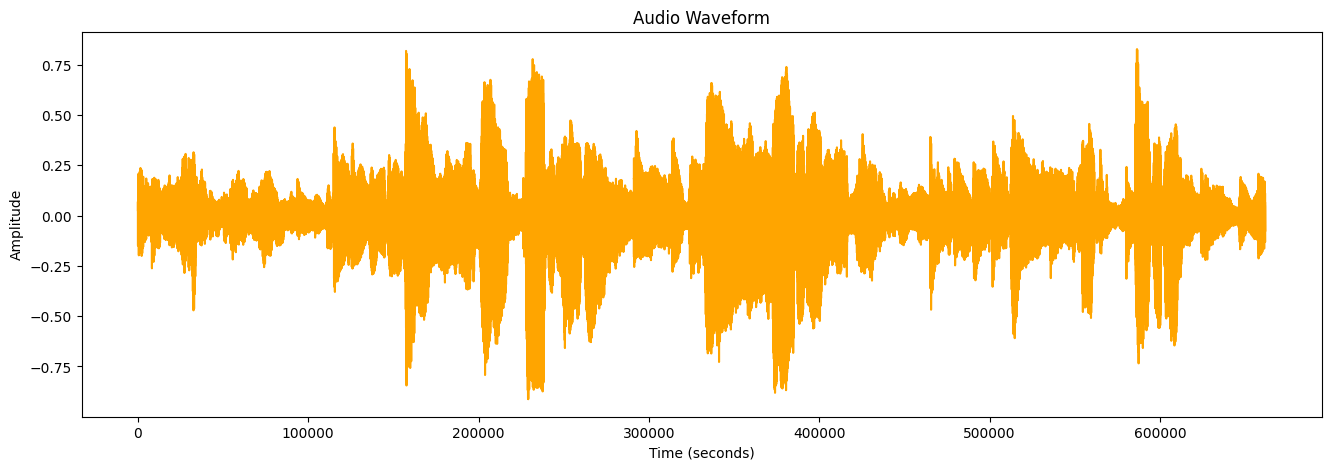

In [ ]:
# Visualizing audio file as a waveform
plt.figure(figsize=(16, 5))

# Plot the waveform
plt.plot(x,color = 'orange')

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')

# Show the plot
plt.show()

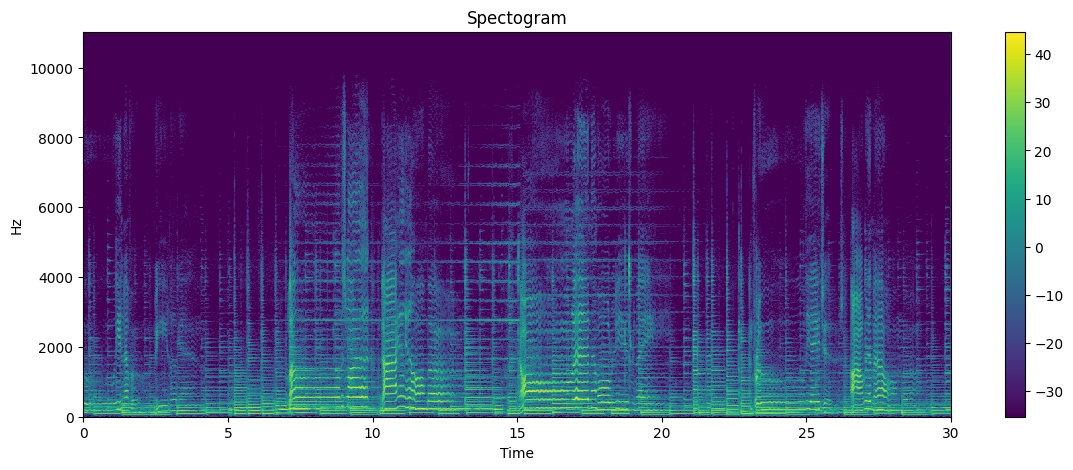

In [ ]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='viridis')
plt.title('Spectogram')
plt.colorbar()

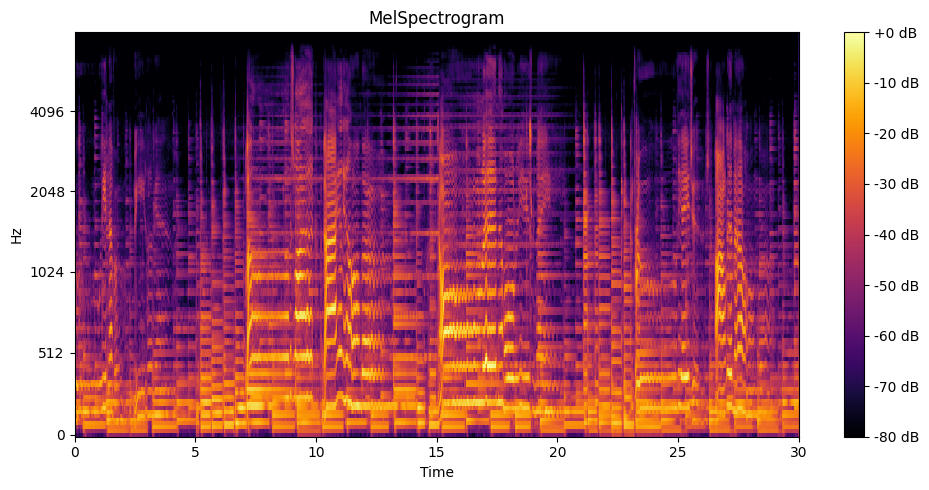

In [ ]:
# Visualizing Audio as Mel-Spectogram

file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap = 'inferno')
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

In [ ]:
DATASET_PATH = 'Music Class/DATA/genre_org/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def mfcc_save(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we are processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file

                file_path = os.path.join(dirpath, f)

                if file_path != 'Music Class/DATA/genre_org/jazz/jazz.00054.wav':  # this is a corrupt file

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)


                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
mfcc_save(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
Music Class/DATA/genre_org/hiphop/hiphop.00086.wav, segment:2
Music Class/DATA/genre_org/hiphop/hiphop.00086.wav, segment:3
Music Class/DATA/genre_org/hiphop/hiphop.00086.wav, segment:4
Music Class/DATA/genre_org/hiphop/hiphop.00086.wav, segment:5
Music Class/DATA/genre_org/hiphop/hiphop.00086.wav, segment:6
Music Class/DATA/genre_org/hiphop/hiphop.00079.wav, segment:1
Music Class/DATA/genre_org/hiphop/hiphop.00079.wav, segment:2
Music Class/DATA/genre_org/hiphop/hiphop.00079.wav, segment:3
Music Class/DATA/genre_org/hiphop/hiphop.00079.wav, segment:4
Music Class/DATA/genre_org/hiphop/hiphop.00079.wav, segment:5
Music Class/DATA/genre_org/hiphop/hiphop.00079.wav, segment:6
Music Class/DATA/genre_org/hiphop/hiphop.00078.wav, segment:1
Music Class/DATA/genre_org/hiphop/hiphop.00078.wav, segment:2
Music Class/DATA/genre_org/hiphop/hiphop.00078.wav, segment:3
Music Class/DATA/genre_org/hiphop/hiphop.00078.wav, segment:4
Music Class/DATA/ge

In [ ]:
DATA_PATH = "./data_10.json"


def data_load(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plt_hist(history):
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prep_data(test_size, validation_size):
    # load data
    X, y, z = data_load(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def make_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prep_data(0.25, 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 107, 6, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 107, 6, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 4, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 2, 128)        0         
 g2D)                                                            
                                                        

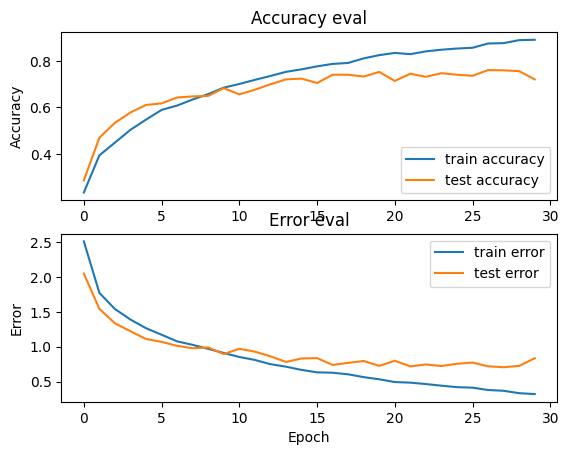

47/47 - 0s - loss: 0.8804 - accuracy: 0.7123 - 260ms/epoch - 6ms/step

Test accuracy: 0.7122830152511597
Epoch 1/30
113/113 [==============================] - 1s 8ms/step - loss: 0.3225 - accuracy: 0.8951 - val_loss: 0.6848 - val_accuracy: 0.7542
Epoch 2/30
113/113 [==============================] - 1s 7ms/step - loss: 0.2943 - accuracy: 0.9024 - val_loss: 0.6671 - val_accuracy: 0.7742
Epoch 3/30
113/113 [==============================] - 1s 8ms/step - loss: 0.2999 - accuracy: 0.9021 - val_loss: 0.7063 - val_accuracy: 0.7642
Epoch 4/30
113/113 [==============================] - 1s 8ms/step - loss: 0.2807 - accuracy: 0.9154 - val_loss: 0.6826 - val_accuracy: 0.7620
Epoch 5/30
113/113 [==============================] - 1s 7ms/step - loss: 0.2676 - accuracy: 0.9143 - val_loss: 0.7275 - val_accuracy: 0.7586
Epoch 6/30
113/113 [==============================] - 1s 8ms/step - loss: 0.2465 - accuracy: 0.9246 - val_loss: 0.6717 - val_accuracy: 0.7842
Epoch 7/30
113/113 [=======================

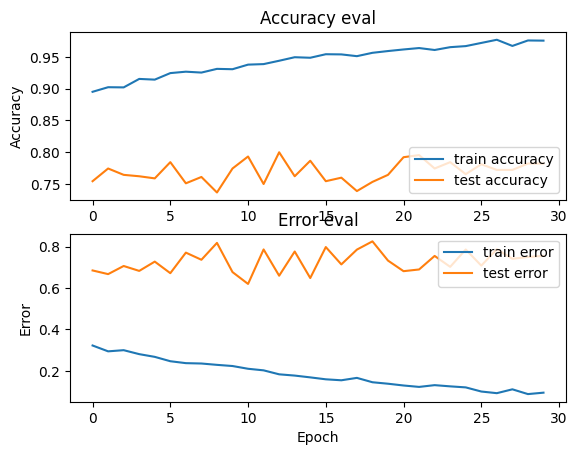

47/47 - 0s - loss: 0.8425 - accuracy: 0.7637 - 159ms/epoch - 3ms/step

Test accuracy: 0.7636849284172058


In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = make_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plt_hist(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plt_hist(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[520]
y_to_predict = y_test[520]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 32ms/step
Target: blues, Predicted label: ['blues']


In [ ]:
saudio_path = music_dataset[52]
genre_name = genre_target[52]
# img_path = './data/images_original/blues/blues00011.png'

x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=None)
print(genre_name)
ipd.Audio(audio_path)

blues


In [ ]:
music_dataset[52]

'Music Class/DATA/genre_org/blues/blues.00056.wav'

In [ ]:
model.save("cnn_model_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test),axis = 1)
preds

47/47 [==============================] - 0s 3ms/step


array([6, 0, 3, ..., 8, 2, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
preds

array([6, 0, 3, ..., 8, 2, 0])

In [ ]:
cm = confusion_matrix(preds,y_test)
cm

array([[ 91,   1,   0,   0,   0,   1,   0,   3,   0,   0],
       [  1,  97,   0,   1,   0,   1,   9,   2,   1,   8],
       [  0,   0, 138,   0,   2,   6,   0,   1,   0,   0],
       [  3,  11,   0, 124,   4,   2,   5,  21,   2,   8],
       [  8,   1,   0,   7, 104,   5,   7,  13,   1,   6],
       [ 11,   1,   0,   1,   7, 128,   0,   2,   0,   3],
       [  0,   3,   0,   3,   0,   0, 103,   1,   0,   2],
       [ 11,   2,   6,  12,  22,   5,   9, 103,  10,   5],
       [ 12,  16,   0,   4,   2,   0,   0,   7, 125,   0],
       [  3,  16,   2,  10,   3,   0,   9,  11,   2, 131]])

Normalized confusion matrix


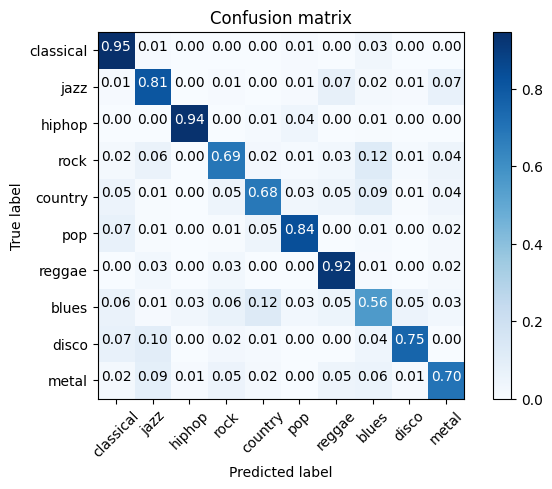

In [ ]:
plot_confusion_matrix(cm,set(genre_target),normalize=True)

In [ ]:
# loaded_model = load_model("models\manuj_cnn.h5")
# loaded_model.summary()